In [3]:
!git clone https://github.com/khairulimamofficial/old-book-collection-2

Cloning into 'old-book-collection-2'...
remote: Enumerating objects: 1733, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 1733 (delta 0), reused 3 (delta 0), pack-reused 1730
Receiving objects: 100% (1733/1733), 184.54 MiB | 31.47 MiB/s, done.
Resolving deltas: 100% (843/843), done.
Updating files: 100% (1722/1722), done.


In [4]:
!mkdir /content/training
!mkdir /content/training/train
!mkdir /content/training/train/title-page
!mkdir /content/training/train/toc-page
!mkdir /content/training/train/content-page


!mkdir /content/training/validation
!mkdir /content/training/validation/title-page
!mkdir /content/training/validation/toc-page
!mkdir /content/training/validation/content-page

In [5]:
# lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
!ls /content/old-book-collection-2/separated-dataset/title-page/images/* | sort -n | head -5 | xargs -I{} mv {} /content/training/validation/title-page
!ls /content/old-book-collection-2/separated-dataset/toc-page/images/* | sort -n | head -5 | xargs -I{} mv {} /content/training/validation/toc-page
!ls /content/old-book-collection-2/separated-dataset/content-page/images/* | sort -n | head -5 | xargs -I{} mv {} /content/training/validation/content-page

# Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
!ls /content/old-book-collection-2/separated-dataset/title-page/images/* | xargs -I{} mv {} /content/training/train/title-page
!ls /content/old-book-collection-2/separated-dataset/toc-page/images/* | xargs -I{} mv {} /content/training/train/toc-page
!ls /content/old-book-collection-2/separated-dataset/content-page/images/* | xargs -I{} mv {} /content/training/train/content-page

In [6]:
import tensorflow as tf

ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
SIZE = (768, 768, 3)
# Create the base model from the pre-trained model MobileNet V2 which is trained on imagenet Dataset
# which consists of 1.2M labelled images.
imagenet = tf.keras.applications.MobileNetV2(input_shape=SIZE,
                                               include_top=False,
                                               weights='imagenet')
#To tell Tf not to adjust weigths of imagenet model which are already trained
imagenet.trainable = False
#model Summary
imagenet.summary()
#Defining New Model with imagenet as the Base Model using Sequential Api
model = tf.keras.models.Sequential([
    imagenet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])
#Using ImageDataGenerator to ease Data preparation as it lables images based on Folder Name which is ideal for the way Data Set is arranged
TRAINING_DIR = "/content/training/train/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(768, 768))

VALIDATION_DIR = "/content/training/validation/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='categorical',
                                                              target_size=(768, 768))


9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 768, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 384, 384, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 384, 384, 32  128         ['Conv1[0][0]']                  
                

In [10]:
# Model compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Model training
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 24, 24, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 24s 782ms/step - loss: 0.3113 - accuracy: 0.9207 - val_loss: 0.3152 - val_accuracy: 0.8667
Epoch 2/10
27/27 [=============

In [22]:
train_generator.class_indices

{'content-page': 0, 'title-page': 1, 'toc-page': 2}

<Figure size 640x480 with 0 Axes>

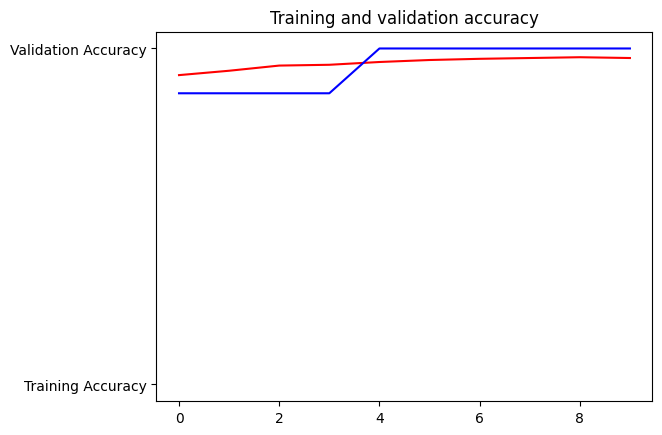

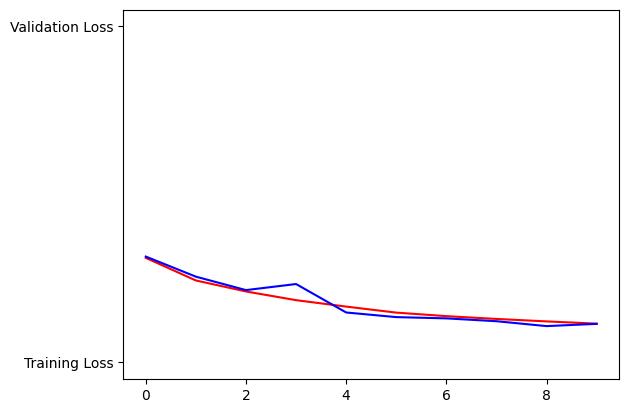

<Figure size 640x480 with 0 Axes>

In [12]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs
#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()
# Desired output. Charts with training and validation metrics. No crash :)

In [20]:
# Model prediction
# Replace 'image_path.jpg' with the path to your input image
image_path = '/content/training/validation/toc-page/0000_101_018.jpg'
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(768, 768))
image = tf.keras.preprocessing.image.img_to_array(image)
image = tf.expand_dims(image, axis=0)
image = image / 255.0  # Normalize the image

predictions = model.predict(image)
predicted_class = tf.argmax(predictions, axis=1)
print(f'Predicted class: {predicted_class[0]}')


1/1 [==============================] - 0s 27ms/step
Predicted class: 2


In [16]:
#Saving Model for future Predictions
model.save('TLmodel.h5')

# Save the model as a .pb file
model.save("model.pb")

# Convert the saved .pb model to TensorFlow Lite (.tflite) format
converter = tf.lite.TFLiteConverter.from_saved_model("model.pb")
tflite_model = converter.convert()

# Save the TensorFlow Lite model as a .tflite file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)